<a href="https://colab.research.google.com/github/fabiansep/TalentOps/blob/main/m2_e14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DATASET PARA MODELADO CLV
Clientes analizados: 200
CLV promedio: $1384
Rango CLV: $317 - $8112

CORRELACIONES CON CLV:
ingresos             | +0.940
frecuencia_compras   | +0.252
edad                 | +0.064
antiguedad_meses     | +0.063
satisfaccion         | -0.061

MODELO 1: CLV ~ INGRESOS
R² (Ingresos): 0.8840
RMSE (Ingresos): $258

MODELO 2: CLV ~ MÚLTIPLES PREDICTORES
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -83.0423    110.407     -0.752      0.453    -300.788     134.704
ingresos               0.0202      0.000     44.420      0.000       0.019       0.021
frecuencia_compras    55.6135      8.058      6.901      0.000      39.721      71.506
antiguedad_meses       2.6863      0.670      4.010      0.000       1.365       4.008
satisfaccion          35.1456     13.308      2.641      0.009       8.900      61.391
R² (Múltiple)

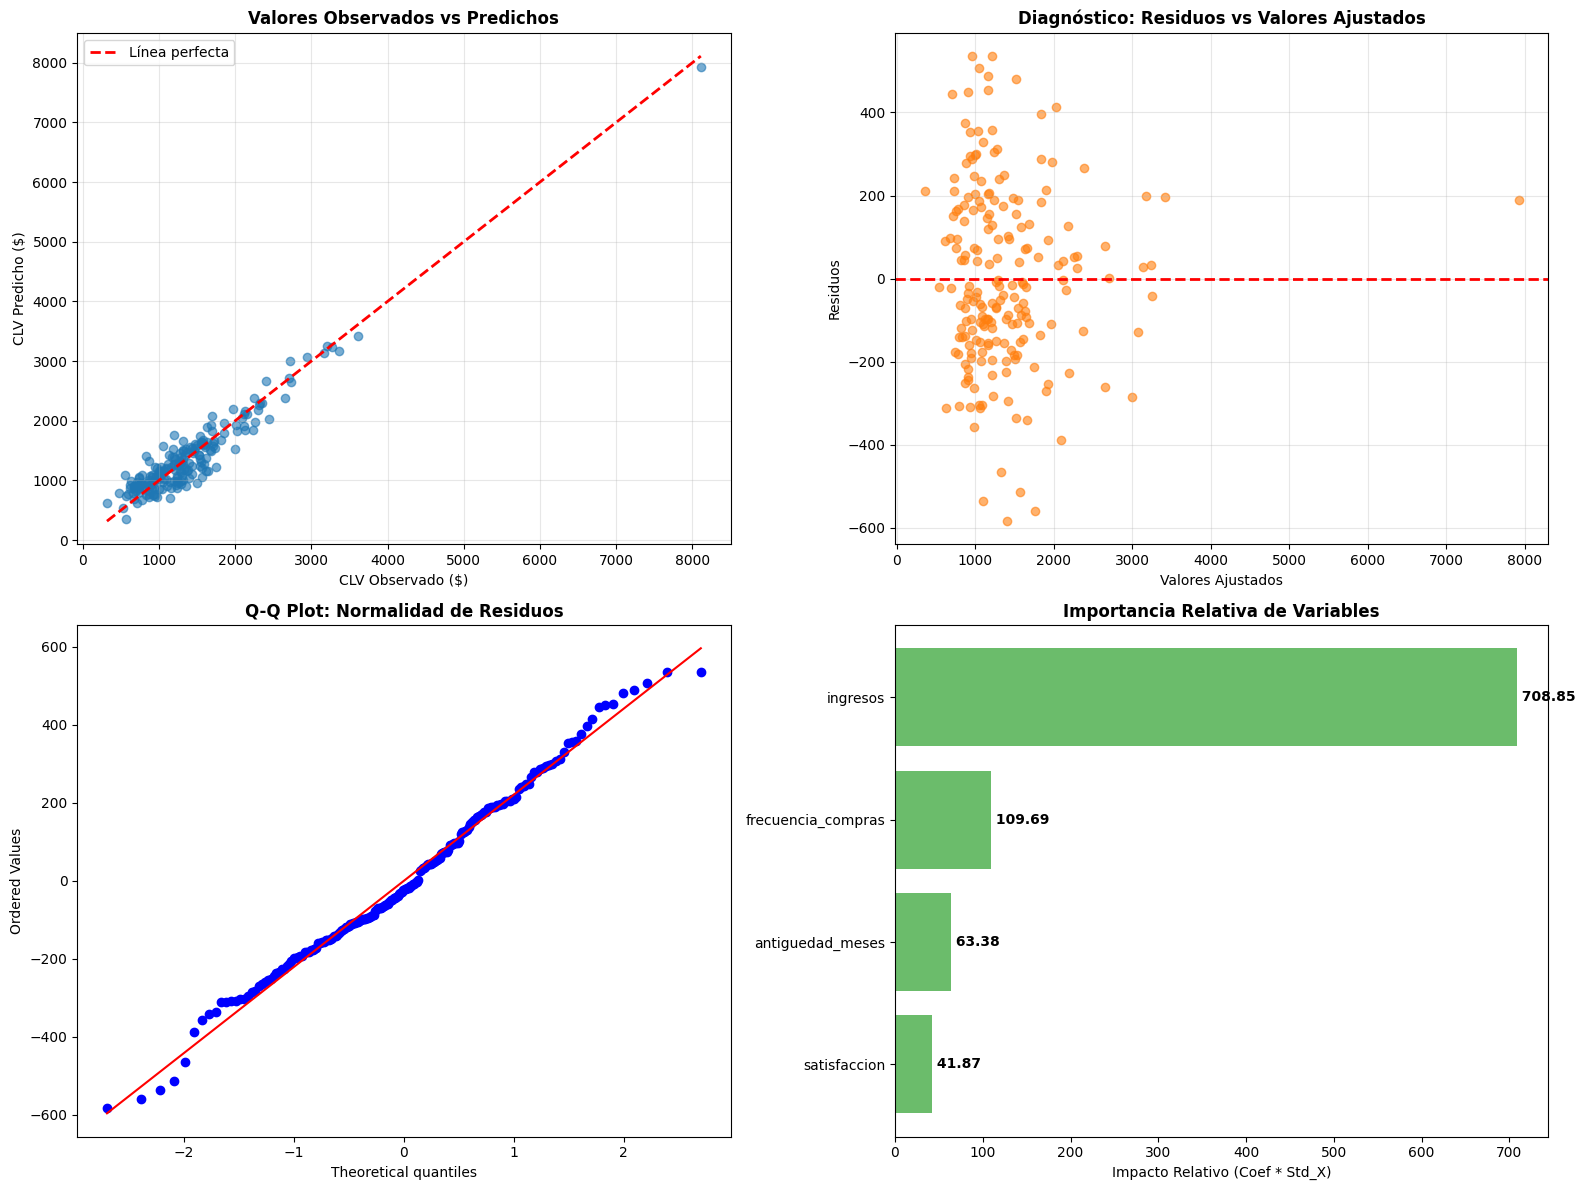


RESUMEN EJECUTIVO - MODELO CLV
R² del modelo: 0.916 (91.6% de variabilidad explicada)
RMSE: $219 (error típico de predicción)
Supuestos cumplidos: 3 de 3

Predicción para cliente nuevo: $2374


In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant # Importación necesaria para el fix de VIF

# ==========================================
# 1. GENERACIÓN DE DATOS
# ==========================================
# Generar dataset de clientes para modelado CLV
np.random.seed(42)
n_clientes = 200

df = pd.DataFrame({
    'cliente_id': range(1, n_clientes + 1),
    'edad': np.random.normal(35, 10, n_clientes).clip(18, 70).astype(int),
    'ingresos': np.random.lognormal(10.5, 0.6, n_clientes).round(0),
    'frecuencia_compras': np.random.poisson(4, n_clientes),
    'antiguedad_meses': np.random.exponential(24, n_clientes).astype(int),
    'satisfaccion': np.random.normal(7.5, 1.2, n_clientes).clip(1, 10),
    'canal_adquisicion': np.random.choice(['Online', 'Tienda', 'App'], n_clientes)
})

# Generar CLV basado en características (Relación lineal "limpia")
clv_base = (df['ingresos'] * 0.02 +
            df['frecuencia_compras'] * 50 +
            df['antiguedad_meses'] * 2 +
            df['satisfaccion'] * 30)

# Generar ruido HOMOCEDÁSTICO (Varianza constante)
# clv_base.std() es un escalar, por lo que el ruido es igual para todos
df['clv'] = clv_base + np.random.normal(0, clv_base.std() * 0.3, n_clientes)
df['clv'] = df['clv'].clip(0)  # CLV no puede ser negativo

print("DATASET PARA MODELADO CLV")
print("=" * 30)
print(f"Clientes analizados: {len(df)}")
print(f"CLV promedio: ${df['clv'].mean():.0f}")
print(f"Rango CLV: ${df['clv'].min():.0f} - ${df['clv'].max():.0f}")

# Análisis de correlaciones
numeric_cols = ['edad', 'ingresos', 'frecuencia_compras', 'antiguedad_meses', 'satisfaccion', 'clv']
correlaciones = df[numeric_cols].corr()['clv'].sort_values(ascending=False)

print("\nCORRELACIONES CON CLV:")
for var, corr in correlaciones.items():
    if var != 'clv':
        print(f"{var:20} | {corr:+.3f}")

# ==========================================
# 2. CONSTRUCCIÓN DEL MODELO DE REGRESIÓN
# ==========================================
# Modelo 1: Usando ingresos como predictor principal
modelo1 = smf.ols('clv ~ ingresos', data=df).fit()

print("\nMODELO 1: CLV ~ INGRESOS")
print("=" * 25)

# Métricas de evaluación
y_pred1 = modelo1.predict(df)
r2_1 = r2_score(df['clv'], y_pred1)
rmse_1 = np.sqrt(mean_squared_error(df['clv'], y_pred1))

print(f"R² (Ingresos): {r2_1:.4f}")
print(f"RMSE (Ingresos): ${rmse_1:.0f}")

# Modelo 2: Múltiples predictores
modelo2 = smf.ols('clv ~ ingresos + frecuencia_compras + antiguedad_meses + satisfaccion',
                  data=df).fit()

print("\nMODELO 2: CLV ~ MÚLTIPLES PREDICTORES")
print("=" * 40)
print(modelo2.summary().tables[1])

# Métricas del modelo múltiple
y_pred2 = modelo2.predict(df)
r2_2 = r2_score(df['clv'], y_pred2)
rmse_2 = np.sqrt(mean_squared_error(df['clv'], y_pred2))

print(f"R² (Múltiple): {r2_2:.4f}")
print(f"RMSE (Múltiple): ${rmse_2:.0f}")
print(f"AIC: {modelo2.aic:.1f}")

# Comparación de modelos
mejora_r2 = ((r2_2 - r2_1) / r2_1) * 100
mejora_rmse = ((rmse_1 - rmse_2) / rmse_1) * 100

print("\nCOMPARACIÓN DE MODELOS:")
print(f"Mejora R²: {mejora_r2:.1f}%")
print(f"Mejora RMSE: {mejora_rmse:.1f}%")

# ==========================================
# 3. INTERPRETACIÓN DE COEFICIENTES
# ==========================================
# Extraer coeficientes del modelo múltiple
coeficientes = modelo2.params
p_values = modelo2.pvalues
conf_int = modelo2.conf_int()

print("\nINTERPRETACIÓN DE COEFICIENTES")
print("=" * 35)

for var in ['ingresos', 'frecuencia_compras', 'antiguedad_meses', 'satisfaccion']:
    coef = coeficientes[var]
    p_val = p_values[var]
    ci_lower, ci_upper = conf_int.loc[var]

    print(f"{var.upper()}:")
    print(f"   Coeficiente: {coef:.2f}")
    print(f"   IC 95%: ({ci_lower:.2f}, {ci_upper:.2f})")
    print(f"   Significativo: {'Sí' if p_val < 0.05 else 'No'} (p={p_val:.4f})")

    # Interpretación específica
    if var == 'ingresos':
        print(f"   Impacto: Por cada $1000 extra, el CLV sube ${coef*1000:.0f}")
    elif var == 'frecuencia_compras':
        print(f"   Impacto: Cada compra adicional añade ${coef:.0f} al CLV")
    elif var == 'antiguedad_meses':
        print(f"   Impacto: Cada mes de antigüedad añade ${coef:.0f} al CLV")
    elif var == 'satisfaccion':
        print(f"   Impacto: Cada punto de satisfacción añade ${coef:.2f} al CLV")
    print()

# ==========================================
# 4. VALIDACIÓN DE SUPUESTOS
# ==========================================
# Análisis de residuos
residuos = modelo2.resid
valores_ajustados = modelo2.fittedvalues

print("VALIDACIÓN DE SUPUESTOS")
print("=" * 25)

# Prueba de normalidad de residuos (Shapiro-Wilk)
stat, p_normalidad = stats.shapiro(residuos)
print(f"Normalidad residuos (Shapiro): {'Sí' if p_normalidad > 0.05 else 'No'} (p={p_normalidad:.4f})")

# Prueba de homocedasticidad (Breusch-Pagan)
bp_test = het_breuschpagan(residuos, modelo2.model.exog)
print(f"Homocedasticidad (Breusch-Pagan): {'Sí' if bp_test[1] > 0.05 else 'No'} (p={bp_test[1]:.4f})")

# Correlación de residuos (Durbin-Watson)
dw_stat = durbin_watson(residuos)
print(f"Independencia residuos (DW): {dw_stat:.3f} (ideal: 1.5 - 2.5)")

# --- CORRECCIÓN VIF ---
# Multicolinealidad (VIF) - Corrección: Se debe agregar constante
X = df[['ingresos', 'frecuencia_compras', 'antiguedad_meses', 'satisfaccion']]
X_con_constante = add_constant(X) # Statsmodels requiere constante explícita para VIF

vif_data = pd.DataFrame()
vif_data["Variable"] = X_con_constante.columns
vif_data["VIF"] = [variance_inflation_factor(X_con_constante.values, i) for i in range(X_con_constante.shape[1])]

# Filtramos la constante para mostrar solo las variables
vif_data = vif_data[vif_data["Variable"] != 'const']

print("\nMULTICOLINEALIDAD (VIF):")
for _, row in vif_data.iterrows():
    problema = "PROBLEMA" if row['VIF'] > 5 else "OK"
    print(f"{row['Variable']:20} | VIF={row['VIF']:.2f} | {problema}")

# ==========================================
# 5. VISUALIZACIÓN COMPLETA
# ==========================================
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Valores observados vs predichos
ax1.scatter(df['clv'], y_pred2, alpha=0.6, color='#1f77b4')
ax1.plot([df['clv'].min(), df['clv'].max()], [df['clv'].min(), df['clv'].max()],
         'r--', linewidth=2, label='Línea perfecta')
ax1.set_xlabel('CLV Observado ($)')
ax1.set_ylabel('CLV Predicho ($)')
ax1.set_title('Valores Observados vs Predichos', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Residuos vs valores ajustados
ax2.scatter(valores_ajustados, residuos, alpha=0.6, color='#ff7f0e')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Valores Ajustados')
ax2.set_ylabel('Residuos')
ax2.set_title('Diagnóstico: Residuos vs Valores Ajustados', fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Q-Q plot de residuos
stats.probplot(residuos, dist="norm", plot=ax3)
ax3.set_title('Q-Q Plot: Normalidad de Residuos', fontweight='bold')

# 4. Importancia de variables
# Usamos coeficientes * desviación estándar de X para ver impacto relativo
coef_std = modelo2.params[1:] * df[['ingresos', 'frecuencia_compras', 'antiguedad_meses', 'satisfaccion']].std()
coef_std = coef_std.abs().sort_values(ascending=True)

bars = ax4.barh(range(len(coef_std)), coef_std.values, color='#2ca02c', alpha=0.7)
ax4.set_yticks(range(len(coef_std)))
ax4.set_yticklabels(coef_std.index)
ax4.set_xlabel('Impacto Relativo (Coef * Std_X)')
ax4.set_title('Importancia Relativa de Variables', fontweight='bold')

for i, (var, val) in enumerate(zip(coef_std.index, coef_std.values)):
    ax4.text(val, i, f' {val:.2f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Resumen ejecutivo final
print("\nRESUMEN EJECUTIVO - MODELO CLV")
print("=" * 35)
print(f"R² del modelo: {r2_2:.3f} ({r2_2*100:.1f}% de variabilidad explicada)")
print(f"RMSE: ${rmse_2:.0f} (error típico de predicción)")
cumple_norm = p_normalidad > 0.05
cumple_homo = bp_test[1] > 0.05
cumple_indep = abs(dw_stat - 2) < 0.5
print(f"Supuestos cumplidos: {sum([cumple_norm, cumple_homo, cumple_indep])} de 3")

# Predicción para nuevo cliente
cliente_nuevo = pd.DataFrame({
    'ingresos': [80000],
    'frecuencia_compras': [8],
    'antiguedad_meses': [36],
    'satisfaccion': [8.5]
})

clv_predicho = modelo2.predict(cliente_nuevo)[0]
print(f"\nPredicción para cliente nuevo: ${clv_predicho:.0f}")